In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import sys
sys.path.append("./CLIP")
# import os
import clip
import torch
from PIL import Image
from IPython.display import Image as ImageDisplay
from utils import load_pickle
import numpy as np
from matplotlib.image import imread
from matplotlib.pyplot import figure, imshow, axis
from jupyter_utils import plot_time_jupyter, plot_scores_jupyter
import time

device = "cuda" if torch.cuda.is_available() else "cpu"

# Below cell contains a helper function for displaying a batch of images (e.g., top scoring images). Feel free to modify the block_size/size parameters for better display on your monitor.

In [2]:
def display_top_query_from_meta(metadata_list, fill=True, score_list=[]):
    """Display a batch of images from a list of Metadata objects (get_path() will return the absolute image file path)
    Args:
        metadata_list : List of Metadata objects (typically the length should be around 50)
        fill : Set to true if you want to resize the images fill the grids
        score_list : The clip score associated with each image (optional)
    """
    list_of_files = [meta.get_path() for meta in metadata_list]
    block_size = int(len(list_of_files)/20)
    size = (20+20*block_size,20+90*block_size)
    print("Plot size is " + str(size))
    fig = figure(figsize=size, tight_layout=True)
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(number_of_files,3,i+1)
        image = imread(list_of_files[i])
#         imshow(image,cmap='Greys_r')
        if fill:
            imshow(image,aspect="auto")
        else:
            imshow(image)
        if len(score_list) > 0:
            title=score_list[i]
            plt.title(title, fontsize=30); 
        axis('off')

# Below cell contains several datasets that I have prepared for you. These include:
- Smallest (for debug purpose)
- Medium (2740000 images)
- Large (7850000 images, the one we used in CLEAR paper
- Larger (??, I will still downloading more images, stay tuned)

# I also extracted CLIP features using 3 models (larger models may perform better):
- ResNet50 (RN50)
- ResNet50x4 (RN50x4)
- ResNet101 (RN101)

In [4]:
from prepare_dataset import get_knearest_models_func, load_bucket_dict
import faiss_utils
from faiss_utils import KNearestFaissFeatureChunks

# Smallest size + shorter edge larger than 120px + max aspect ratio smaller than 2
SMALLEST_DATASET = "/scratch/zhiqiu/yfcc100m_all_new/images_minbyte_10_valid_uploaded_date_minedge_120_maxratio_2.0/"
# Medium size 2740000
MEDIUM_DATASET = "/scratch/zhiqiu/yfcc100m_all/images_minbyte_10_valid_uploaded_date_jan_31/" 
# Large size 7850000 (the one we used in CLEAR paper)
LARGE_DATASET = "/scratch/zhiqiu/yfcc100m_all/images_minbyte_10_valid_uploaded_date_feb_28/" 
TRINITY_DATASETS = {
    'SMALLEST_RN50' : {
        'folder_path' : SMALLEST_DATASET,
        'model_name' : 'RN50',
        'num_of_bucket' : 11
    },
    'SMALLEST_RN50x4' : {
        'folder_path' : SMALLEST_DATASET,
        'model_name' : 'RN50x4',
        'num_of_bucket' : 11
    },
    'SMALLEST_RN101' : {
        'folder_path' : SMALLEST_DATASET,
        'model_name' : 'RN101',
        'num_of_bucket' : 11
    },
    'MEDIUM_RN50' : {
        'folder_path' : MEDIUM_DATASET,
        'model_name' : 'RN50',
        'num_of_bucket' : 11
    },
    'MEDIUM_RN50x4' : {
        'folder_path' : MEDIUM_DATASET,
        'model_name' : 'RN50x4',
        'num_of_bucket' : 11
    },
    'MEDIUM_RN101' : {
        'folder_path' : MEDIUM_DATASET,
        'model_name' : 'RN101',
        'num_of_bucket' : 11
    },
    'LARGE_RN50' : {
        'folder_path' : LARGE_DATASET,
        'model_name' : 'RN50',
        'num_of_bucket' : 11
    },
    'LARGE_RN50x4' : {
        'folder_path' : LARGE_DATASET,
        'model_name' : 'RN50x4',
        'num_of_bucket' : 11
    },
    'LARGE_RN101' : {
        'folder_path' : LARGE_DATASET,
        'model_name' : 'RN101',
        'num_of_bucket' : 11
    },
}


# You should change the DATASET_NAME in below cell to switch between different features and datasets.

In [11]:
# Before running this cell, first need to make sure that you already run prepare_dataset.py to extract the CLIP features
# Change the dataset name for different size dataset or CLIP model used for feature extraction
# DATASET_NAME = "SMALLEST_RN50"
DATASET_NAME = "SMALLEST_RN50x4" # Change this line to switch dataset/features used

folder_path = TRINITY_DATASETS[DATASET_NAME]['folder_path']
model_name = TRINITY_DATASETS[DATASET_NAME]['model_name']
num_of_bucket = TRINITY_DATASETS[DATASET_NAME]['num_of_bucket']

# k_near_faiss = KNearestFaiss(folder_path, model_name)
model, preprocess = clip.load(model_name, device='cpu')
k_nearest_func = get_knearest_models_func(folder_path, model_name, num_of_bucket, model, preprocess)
bucket_dict = load_bucket_dict(folder_path, num_of_bucket)

# A helper functions to collect top score images associated with any query.
def grab_top_query_images(bucket_index, query, start_idx=0, end_idx=40):
    start = time.time()
    k_near_faiss = k_nearest_func(bucket_index)
    normalize_text_feature = k_near_faiss.get_normalized_text_feature(query)
    end_feature = time.time()
    bucket_dict[bucket_index]['flickr_accessor']
    score_list, meta_list = k_near_faiss.k_nearest_meta(bucket_dict[bucket_index]['flickr_accessor'], normalize_text_feature, k=end_idx)
    end_search = time.time()
    print(f"{end_feature-start:.4f} for computing features. {end_search-end_feature} for computing KNN.")
#     print(f"length is {len(meta_list)} and {len(meta_list[start_idx:end_idx])}")
    assert len(meta_list) == len(meta_list[start_idx:end_idx])
    return score_list[start_idx:end_idx], meta_list[start_idx:end_idx]

# Below cell contains examplar prompts. It would be interesting to try some of them out.

In [6]:
# This cell contains many examplary prompt
fruit_apple = 'a photo of apple, a type of fruit'
phone_apple = 'a photo of apple, a type of phone'
logo_apple = 'a photo of apple, a type of logo'
expensive_apple = 'a photo of expensive apple'
cheap_apple = 'a photo of cheap apple'
just_apple = 'a photo of apple'

just_an_apple = 'a photo of an apple'
just_apples = 'a photo of apples'
just_apple = 'a photo of apple'
apple_tree = 'a photo of apple tree'

no_apple = 'no apple'

old_apple = 'a photo of apple, which is old'
new_apple = 'a photo of apple, which is new'
fresh_apple = 'a photo of apple, which is fresh'
rotten_apple = 'rotten apple'
pretty_apple = 'a photo of apple, which is pretty'
ugly_apple = 'a photo of apple, which is ugly'
broken_apple = 'broken apple'
no_function_apple = 'not functioning apple'


old_car = "a photo of a car, which is old"
a1980_car = "a photo of a car in 1980s"
n2004_car = "a photo of a car in 2004"
n2005_car = "a photo of a car in 2005"
n2006_car = "a photo of a car in 2006"
n2007_car = "a photo of a car in 2007"
n2008_car = "a photo of a car in 2008"
n2009_car = "a photo of a car in 2009"
n2010_car = "a photo of a car in 2010"
n2011_car = "a photo of a car in 2011"
n2012_car = "a photo of a car in 2012"
n2013_car = "a photo of a car in 2013"
n2014_car = "a photo of a car in 2014"
a2010_car = "a photo of a car in 2010s"
new_car = "a photo of a car, which is new"
broken_car = "a photo of a car, which is broken"
just_car = "a photo of a car"

old_bike = "a photo of a bike, which is old"
new_bike = "a photo of a bike, which is new"
broken_bike = "a photo of a bike, which is broken"
just_bike = "a photo of a bike"

old_motorcycle = "a photo of a motorcycle, which is old"
new_motorcycle = "a photo of a motorcycle, which is new"
broken_motorcycle = "a photo of a motorcycle, which is broken"
just_motorcycle = "a photo of a motorcycle"
just_motorcycles = "a photo of motorcycles"

old_motorbike = "a photo of a motorbike, which is old"
new_motorbike = "a photo of a motorbike, which is new"
broken_motorbike = "a photo of a motorbike, which is broken"
just_motorbike = "a photo of a motorbike"
only_motorbike = "only motorbike"
motorbike_and_car = "motorbike and car"

no_car_motorbike = "a photo of a motorbike, no car"

old_jet = "a photo of a jet, which is old"
new_jet = "a photo of a jet, which is new"
broken_jet = "a photo of a jet, which is broken"

old_shirt = "a photo of a t-shirt, which is old"
new_shirt = "a photo of a t-shirt, which is new"

n2004 = 'a photo in 2004'
n2014 = 'a photo in 2014'
n1980 = 'a photo in 1980'
n2020 = 'a photo in 2020'


mouse_animal = 'a photo of mouse, a type of animal'
mouse_accessory = 'a photo of mouse, a type of accessory'
just_mouse = 'a photo of mouse'
just_star = 'a photo of star'

obama = 'obama'
trump = 'trump'
president = 'a photo of president'
curr_president = 'a photo of current president'
vice_president = 'a photo of vice president'
presidential_debate = "presidential debate"

# To collect top scoring images per bucket (segment)
- You should run the below cell to collect top scoring images with respect to a query.
- The bucket index starts from 0 to 10. (in total there are 11 buckets sorted by date uploaded)
- start_idx and end_idx refers to the ranks of images you are searching for. For example, the current cell will return the first 1000 top scoring images with respect to prompt "A photo of a motorcycle".

In [12]:
bucket_index = 1 # Change it to different buckets to perform search in different time period.
clip_scores, metadata_lst = grab_top_query_images(
                                        bucket_index,
                                        "A photo of a motorcycle",
                                        start_idx=0,
                                        end_idx=1000
                                    )
print(len(metadata_lst))

/scratch/zhiqiu/yfcc100m_all_new/images_minbyte_10_valid_uploaded_date_minedge_120_maxratio_2.0/bucket_11/1/features_RN50x4.pickle
Loaded from /scratch/zhiqiu/yfcc100m_all_new/images_minbyte_10_valid_uploaded_date_minedge_120_maxratio_2.0/bucket_11/1/features_RN50x4.pickle
Already exists: /scratch/zhiqiu/yfcc100m_all_new/images_minbyte_10_valid_uploaded_date_minedge_120_maxratio_2.0/bucket_11/1/features_RN50x4/features_0_normalized.pickle
Current chunk has 9091 features
3.1120 seconds for searching.
3.1147 seconds for one iteration.
0.5459 for computing features. 3.115703582763672 for computing KNN.
1000


# To display the collected images and their respective clip scores

Plot size is (60, 200)


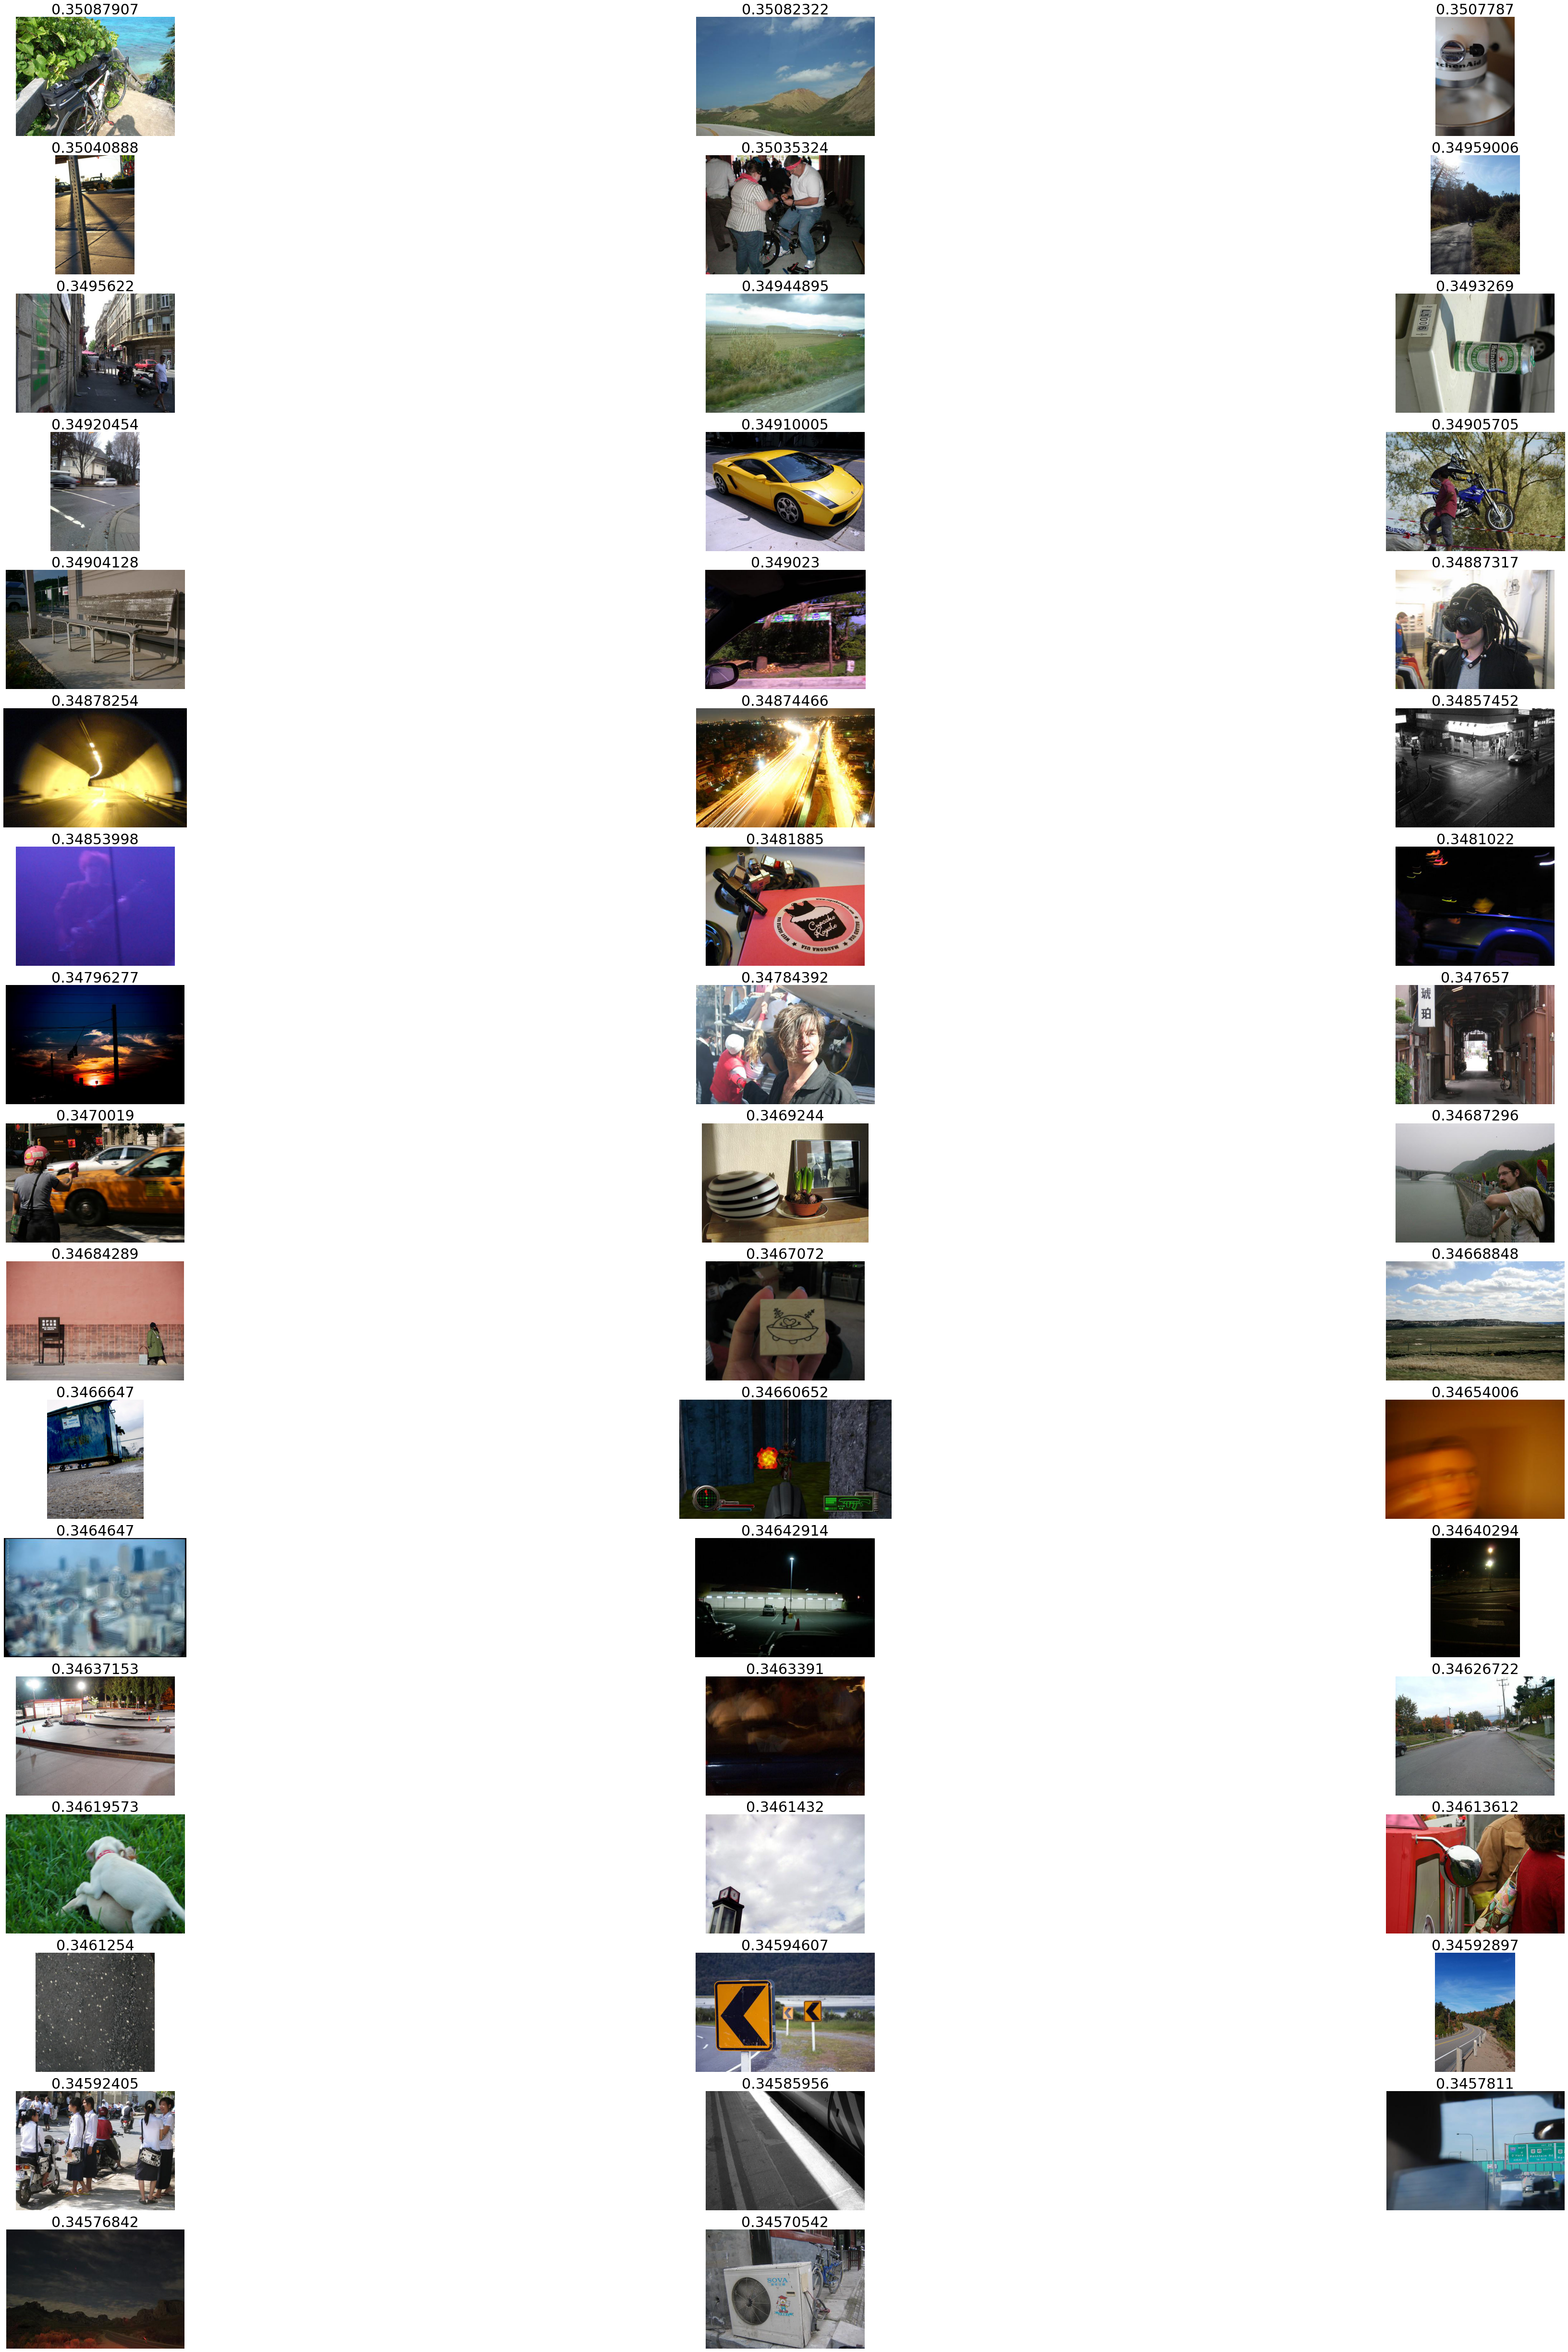

In [14]:
start=100 # The starting index 
end=start+50 # The end index
display_top_query_from_meta(metadata_lst[start:end], fill=False, score_list=clip_scores[start:end])

# You can use get_path() to retrieve the absolute file path of any image

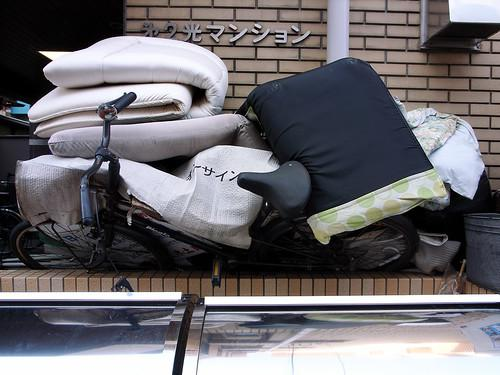

In [15]:
image_path = metadata_lst[8].get_path()
ImageDisplay(image_path)


# A few more examples

In [16]:
apple_scores, apple_lst = grab_top_query_images("A photo of a apple", start_idx=0, end_idx=1000)

TypeError: grab_top_query_images() missing 1 required positional argument: 'query'

In [ ]:
# display_top_query_from_meta(apple_lst[:50], fill=False, score_list=apple_scores[:50])
start=300
end=start+50
display_top_query_from_meta(apple_lst[start:end], fill=False, score_list=apple_scores[start:end])
print(apple_scores[end])

In [ ]:
plot_scores_jupyter(apple_scores)

In [ ]:
bike_scores, bike_lst = grab_top_query_images("A photo of a bike", start_idx=0, end_idx=10000)

In [ ]:
start=600
end=start+50
display_top_query_from_meta(bike_lst[start:end], fill=False, score_list=bike_scores[start:end])
print(bike_scores[end])
# print(bike_lst[8].get_path())

In [ ]:
bike_no_motor_bike_scores, bike_no_motor_bike_lst = grab_top_query_images_difference("A photo of a bike", diff_queries=['A photo of a motorcycle'],\
                                                                     start_idx=0, end_idx=10000, lmb=1.)



In [ ]:
start=500
end=start+50
display_top_query_from_meta(bike_no_motor_bike_lst[start:end], fill=False, score_list=bike_no_motor_bike_scores[start:end])
print(bike_no_motor_bike_scores[end])

In [ ]:
bike_no_motor_bike_no_car_scores, bike_no_motor_bike_no_car_lst = grab_top_query_images_difference("A photo of a bike", \
                                                                                                   diff_queries=['A photo of a motorcycle', 'A photo of a car'],\
                                                                     start_idx=0, end_idx=10000, lmb=1.)




In [ ]:
start=600
end=start+50
display_top_query_from_meta(bike_no_motor_bike_no_car_lst[start:end], fill=False, score_list=bike_no_motor_bike_no_car_scores[start:end])
print(bike_no_motor_bike_no_car_scores[end])

In [ ]:
car_scores, car_lst = grab_top_query_images("A photo of car", start_idx=0, end_idx=4000)

In [ ]:
# meta_lst = grab_top_query_images(phone_apple, start_idx=0, end_idx=2049)
# plot_time_jupyter(meta_lst)

In [ ]:
lst = grab_top_query_images(fruit_apple, start_idx=0, end_idx=500)
plot_time_jupyter(lst)

In [ ]:
lst = grab_top_query_images(fruit_apple, start_idx=0, end_idx=5000)
plot_time_jupyter(lst)

In [ ]:
# ImageDisplay("/scratch/zhiqiu/yfcc100m_all/images_minbyte_10_valid_uploaded_date_jan_25/37/images/11052978605.png")